In [2]:
import matplotlib.pyplot as plt
import librosa
import numpy as np
import pyworld as pw
from scipy.interpolate import interp1d
def _calculate_f0(input: np.ndarray,sr,f0min,f0max,
                      use_continuous_f0: bool=False,
                      use_log_f0: bool=True) -> np.ndarray:
        input = input.astype(float)
        frame_period = 378198/16000/1181*1000
        #print(frame_period)
        f0, timeaxis = pw.dio(
            input,
            fs=sr,
            f0_floor=f0min,
            f0_ceil=f0max,
            frame_period=frame_period)
        f0 = pw.stonemask(input, f0, timeaxis, sr)
        if use_continuous_f0:
            f0 = _convert_to_continuous_f0(f0)
        if use_log_f0:
            nonzero_idxs = np.where(f0 != 0)[0]
            f0[nonzero_idxs] = np.log(f0[nonzero_idxs])
        return f0.reshape(-1)
def _convert_to_continuous_f0(f0: np.ndarray) -> np.ndarray:
    if (f0 == 0).all():
        print("All frames seems to be unvoiced.")
        return f0

    # padding start and end of f0 sequence
    start_f0 = f0[f0 != 0][0]
    end_f0 = f0[f0 != 0][-1]
    start_idx = np.where(f0 == start_f0)[0][0]
    end_idx = np.where(f0 == end_f0)[0][-1]
    f0[:start_idx] = start_f0
    f0[end_idx:] = end_f0

    # get non-zero frame index
    nonzero_idxs = np.where(f0 != 0)[0]

    # perform linear interpolation
    interp_fn = interp1d(nonzero_idxs, f0[nonzero_idxs])
    f0 = interp_fn(np.arange(0, f0.shape[0]))

    return f0
    
def getkey(key):
    return np.power(2,key/12.0)

In [5]:
audiofile='G:/Dataset/standardtest/voice/male/ch_00001.wav'
#audiofile='E:/Codedata/SVCVITS/test3.wav'
wav, sr = librosa.load(audiofile,sr=None)
print(wav.shape,sr)
if len(wav.shape) > 1:
    wav = librosa.to_mono(wav)  
f0=_calculate_f0(wav,sr,
            f0min=librosa.note_to_hz('C2'),
            f0max=librosa.note_to_hz('C7'))
#print(f0)

(5193728,) 44100


5.0927206082942735 E3


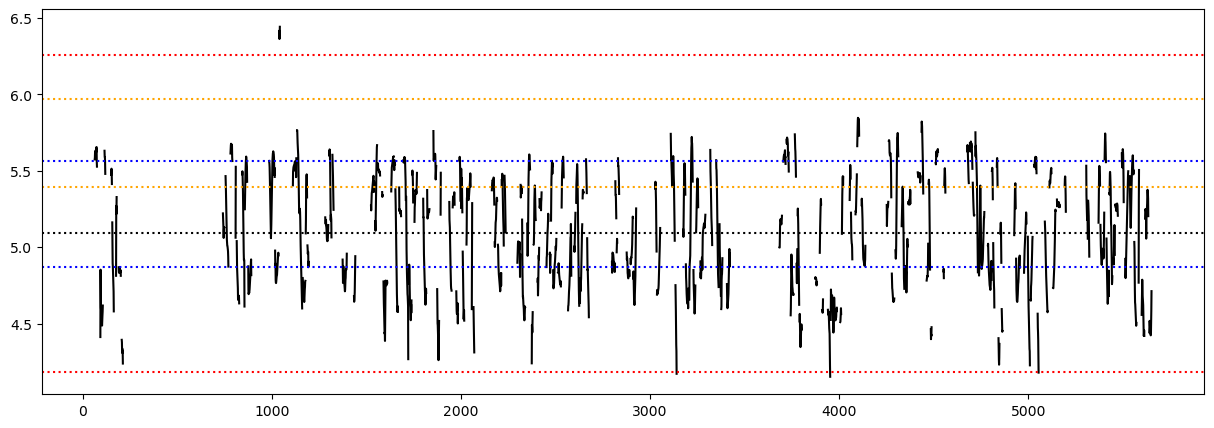

In [6]:
f0=np.nan_to_num(f0)
f0mean=np.mean(f0[f0!=0])
print(f0mean,librosa.hz_to_note(np.e**f0mean))
f0[f0==0]=np.nan
fig=plt.figure(figsize=[15,5])
plt.plot(np.arange(0,len(f0)),f0,color='black')
plt.axhline(y=f0mean,ls=":",c="black")
plt.axhline(y=np.log(librosa.note_to_hz('C2')),ls=":",c="red")
plt.axhline(y=np.log(librosa.note_to_hz('C3')),ls=":",c="blue")
plt.axhline(y=np.log(librosa.note_to_hz('A3')),ls=":",c="orange")
plt.axhline(y=np.log(librosa.note_to_hz('C4')),ls=":",c="blue")
plt.axhline(y=np.log(librosa.note_to_hz('G4')),ls=":",c="orange")
plt.axhline(y=np.log(librosa.note_to_hz('C5')),ls=":",c="red")
plt.show()

In [7]:
librosa.hz_to_note(179.8)

'F♯3'